Image classification with CNNs
================

This notebook is based on the exercise notebooks of the course "Introduction to Deep Learning". We used a three-layer CNN to perform the classification task on the dataset CIFAR10 (32x32 images with 10 classes).

The bullet points are my suggestions what we need to do. 
****
The text below the grey lines is still from the original notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [2]:
from exercise_code.classifiers.classification_cnn import ClassificationCNN
# specific for CIFAR10 dataset:
from exercise_code.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Dataset
=========

* Load the preprocessed datasets in patches of the same size (input size of network so far 32x32 pixel)
* Split data in train - val - test data
* How to treat unequal distribution of benign and malingant cases?

****
For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the <code>Dataset</code> classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the <code>Dataset</code> classes. See <code>torchvision.Transform</code> for examples.</p>
</div> 

In [3]:
from exercise_code.data_utils import load_mammography_data

train_data = load_mammography_data('data/train2.txt')
val_data = load_mammography_data('data/val2.txt')
test_data = load_mammography_data('data/test2.txt')


# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 70
Val size: 23
Test size: 23


Visualize Data
------------------
* Visualize some of the patches with according classlabels 

****
To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

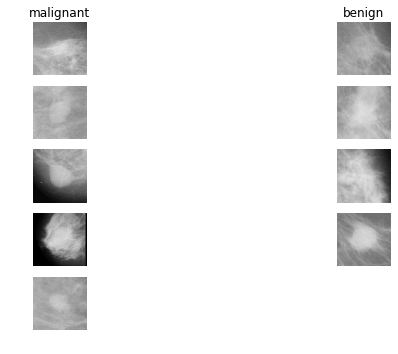

In [4]:
### TODO
classes = ['malignant', 'benign']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0))# + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
#Example from Cifar10 website
#draw_sample(X_train, y_train, 0, 3, 5)

## Train the Network

* Plot validation and training curve
* Hyperparameter optimization
* Visualize filters to see if network learns meaningful features

We can copy each of these methods from the notebooks 1_classification_cnn and 2_segmentation_nn


****


For the testing we start with one image. So we can see if it is training or not

In [6]:
#type([train_data_one])

In [7]:
train_data_ten = train_data[0:3]
#print(train_data_one)
#val_data_one = [val_data[1]]
#print(val_data_one)
type(train_data_ten)
#train_data_ten
#val_data = load_mammography_data('data/val.txt')
#test_data = load_mammography_data('data/test.txt')

list

In [8]:
from exercise_code.classifiers.classification_mammograms import ClassificationCNN
from exercise_code.solver_my import Solver
import torch.nn.functional as F

In [17]:
num_epochs = 30
#deep learning they use batch_size 10
#Here is the case that when i use 96 as batch_size i get a high acc
batch_size = [9]#128]#96]#,32]

#regs = [1e-5]
#weight_scales = [1e-3]
learning_rates = [1e-3]#,5e-4]

for batch in batch_size:
    train_loader = torch.utils.data.DataLoader(train_data_ten, batch_size=batch, shuffle=True, num_workers=1)
    #val_loader = torch.utils.data.DataLoader(val_data_ten, batch_size=batch, shuffle=False, num_workers=1)
    for lr in learning_rates:
       # for reg in regs:
        model = ClassificationCNN()
        model.to(device)
        solver = Solver(optim_args={"lr": lr, 
                                        #"betas": (0.9, 0.999),
                                        #"eps": 1e-8,
                                        "weight_decay": 0.001},
                       loss_func=torch.nn.CrossEntropyLoss(#size_average=True, 
                           ignore_index=-1))
        #log_nth=1000 in deep learning it's 5 and epochs 5
        solver.train(model, train_loader, train_loader, log_nth=1000, num_epochs=num_epochs)
        print(lr,batch)          


START TRAIN.
[Epoch 1/30] TRAIN loss: 8.102535247802734, acc: 0.0
[Epoch 1/30] VAL loss: 2.86418080329895, acc: 1.0
[Epoch 2/30] TRAIN loss: 2.871856689453125, acc: 0.6666666666666666
[Epoch 2/30] VAL loss: 1.6946710348129272, acc: 0.6666666666666666
[Epoch 3/30] TRAIN loss: 2.0183677673339844, acc: 0.6666666666666666
[Epoch 3/30] VAL loss: 2.9554290771484375, acc: 0.3333333333333333
[Epoch 4/30] TRAIN loss: 4.258539199829102, acc: 0.3333333333333333
[Epoch 4/30] VAL loss: 2.1730568408966064, acc: 0.6666666666666666
[Epoch 5/30] TRAIN loss: 2.0201451778411865, acc: 0.6666666666666666
[Epoch 5/30] VAL loss: 1.967542290687561, acc: 0.6666666666666666
[Epoch 6/30] TRAIN loss: 1.8983272314071655, acc: 0.6666666666666666
[Epoch 6/30] VAL loss: 1.4609113931655884, acc: 0.6666666666666666
[Epoch 7/30] TRAIN loss: 1.3635673522949219, acc: 0.6666666666666666
[Epoch 7/30] VAL loss: 1.1616615056991577, acc: 0.6666666666666666
[Epoch 8/30] TRAIN loss: 1.251473307609558, acc: 0.6666666666666666
[Ep

Our loss should be in the end around $-ln(0.5)=0.6931$ 

$0.5$ because we only have two labels.

Why is the train loss under 0.69 in the training above?


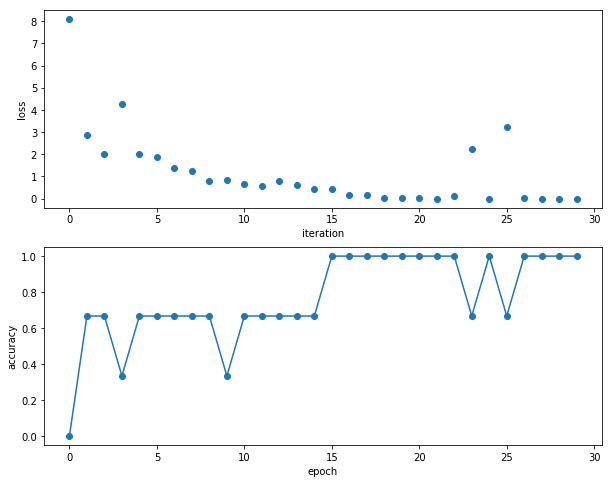

In [18]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
#plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
#plt.axis([xmin, xmax, ymin, ymax])
#plt.axis(ymax=4)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
#plt.plot(solver.val_acc_history, '-o')
#plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Test your Model
Run your best model on the test set.

## Save the Model